In [1]:
import deepchem as dc
from rdkit import Chem
from torch_geometric.data import Data, Batch
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, GraphNorm
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from minisom import MiniSom
from torch.utils.data import Dataset
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [3]:
# 1. Load QM9 dataset with multiple properties
tasks, datasets, _ = dc.molnet.load_qm9(featurizer='GraphConv')
train_dataset, _, _ = datasets
N = len(train_dataset)  # Trainig from entire QM9 dataset
 

# Property indices in QM9:
property_indices = [1, 2, 9, 11]  # alpha, HOMO, H, Cv
property_names = ['alpha', 'HOMO', 'H', 'Cv']

smiles_list = []
y_values = []
for i, (_, y, _, ids) in enumerate(train_dataset.iterbatches(batch_size=1, deterministic=True)):
    if i >= N:
        break
    smiles_list.append(ids[0])
    y_values.append(y[0][property_indices])


In [5]:
# 2. Feature extraction
def atom_features(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetTotalDegree(),
        atom.GetFormalCharge(),
        int(atom.GetHybridization()),
        int(atom.GetIsAromatic()),
        atom.GetTotalNumHs(includeNeighbors=True),
        atom.GetMass(),
        atom.GetExplicitValence(),
        atom.GetImplicitValence()
    ]

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()

    x = torch.tensor([atom_features(a) for a in atoms], dtype=torch.float)
    edge_index = []
    for bond in bonds:
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index)

graphs = [smiles_to_graph(s) for s in smiles_list]

# 3. Normalize targets (each property separately)
y_values = np.array(y_values)
scalers = [StandardScaler() for _ in property_indices]
y_scaled = np.column_stack([scaler.fit_transform(y_values[:, i].reshape(-1, 1)) 
                  for i, scaler in enumerate(scalers)])


In [7]:
# 4. Dataset preparation
class GraphDataset(Dataset):
    def __init__(self, graph_data):
        self.graph_data = graph_data
    
    def __len__(self):
        return len(self.graph_data)
    
    def __getitem__(self, idx):
        graph, target = self.graph_data[idx]
        graph.y = torch.tensor(target, dtype=torch.float)
        return graph

data = [(g, y) for g, y in zip(graphs, y_scaled)]
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
train_loader = DataLoader(GraphDataset(train_data), batch_size=32, shuffle=True)
val_loader = DataLoader(GraphDataset(val_data), batch_size=32)


In [9]:
# 5. GNN Encoder
class GNNEncoder(nn.Module):
    def __init__(self, in_channels=9, hidden_channels=64):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels)
        self.gat2 = GATConv(hidden_channels, hidden_channels)
        self.gat3 = GATConv(hidden_channels, hidden_channels)
        self.norm = GraphNorm(hidden_channels)
        self.dropout = nn.Dropout(0.25)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.leaky_relu(self.gat1(x, edge_index))
        x = self.norm(x, batch)
        x = self.dropout(x)
        x = F.leaky_relu(self.gat2(x, edge_index))
        x = x + self.gat3(x, edge_index)
        x = global_mean_pool(x, batch)
        return x

# 6. SOM Soft Layer
class SOMSoftLayer(nn.Module):
    def __init__(self, m, n, dim):
        super().__init__()
        self.m = m
        self.n = n
        self.dim = dim
        self.som = MiniSom(m, n, dim, sigma=0.7, learning_rate=0.3)
        self.initialized = False

    def forward(self, x):
        x_np = x.detach().cpu().numpy()
        if not self.initialized:
            self.som.random_weights_init(x_np)
            self.som.train_batch(x_np, 1000)
            self.initialized = True
        responses = np.array([
            self.som.activation_response([v])[0].flatten()
            for v in x_np
        ])
        return torch.from_numpy(responses).float().to(x.device)

# 7. Model - modified for multiple outputs
class MultiPropertyPredictor(nn.Module):
    def __init__(self, num_properties=4):
        super().__init__()
        self.encoder = GNNEncoder()
        self.som = SOMSoftLayer(3, 3, 64)
        self.som_output_dim = None
        self.num_properties = num_properties
        self.regressor = None

    def forward(self, data):
        x = self.encoder(data)
        som_out = self.som(x)

        if self.som_output_dim is None:
            self.som_output_dim = som_out.shape[1]
            self.regressor = nn.Sequential(
                nn.Linear(64 + self.som_output_dim, 64),
                nn.ReLU(),
                nn.Linear(64, self.num_properties)
            )
            self.regressor.to(x.device)

        combined = torch.cat([x, som_out], dim=1)
        return self.regressor(combined)


In [11]:
# 8. Training
model = MultiPropertyPredictor(num_properties=len(property_indices))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

print("\n Training SOM + GNN for Multiple Properties...\n")
for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        pred = model(batch)
        # Ensure target has shape [batch_size, num_properties]
        target = batch.y.view(-1, len(property_indices))  # Reshape to match pred shape
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:03d} | Loss: {total_loss / len(train_loader):.4f}")



 Training SOM + GNN for Multiple Properties...

Epoch 001 | Loss: 0.9907
Epoch 002 | Loss: 0.9791
Epoch 003 | Loss: 0.9725
Epoch 004 | Loss: 0.9686
Epoch 005 | Loss: 0.9645
Epoch 006 | Loss: 0.9628
Epoch 007 | Loss: 0.9609
Epoch 008 | Loss: 0.9589
Epoch 009 | Loss: 0.9575
Epoch 010 | Loss: 0.9557
Epoch 011 | Loss: 0.9546
Epoch 012 | Loss: 0.9526
Epoch 013 | Loss: 0.9520
Epoch 014 | Loss: 0.9503
Epoch 015 | Loss: 0.9488
Epoch 016 | Loss: 0.9481
Epoch 017 | Loss: 0.9472
Epoch 018 | Loss: 0.9455
Epoch 019 | Loss: 0.9461
Epoch 020 | Loss: 0.9448
Epoch 021 | Loss: 0.9440
Epoch 022 | Loss: 0.9438
Epoch 023 | Loss: 0.9423
Epoch 024 | Loss: 0.9414
Epoch 025 | Loss: 0.9408
Epoch 026 | Loss: 0.9400
Epoch 027 | Loss: 0.9399
Epoch 028 | Loss: 0.9397
Epoch 029 | Loss: 0.9387
Epoch 030 | Loss: 0.9376
Epoch 031 | Loss: 0.9370
Epoch 032 | Loss: 0.9375
Epoch 033 | Loss: 0.9361
Epoch 034 | Loss: 0.9362
Epoch 035 | Loss: 0.9357
Epoch 036 | Loss: 0.9352
Epoch 037 | Loss: 0.9349
Epoch 038 | Loss: 0.9339
E

In [13]:

# 9. Predict Random 100 molecules for all properties
model.eval()
random_indices = random.sample(range(len(graphs)), 100)

# Store predictions and actual values for each property
predictions = {name: [] for name in property_names}
actuals = {name: [] for name in property_names}

with torch.no_grad():
    for i in random_indices:
        graph = graphs[i]
        batch_data = Batch.from_data_list([graph])
        pred_scaled = model(batch_data)[0].cpu().numpy()
        
        # Inverse transform each property
        for j, name in enumerate(property_names):
            actual = y_values[i, j]
            pred = scalers[j].inverse_transform([[pred_scaled[j]]])[0][0]
            
            actuals[name].append(actual)
            predictions[name].append(pred)

# 10. Calculate metrics for each property
print("\n Performance Metrics for Each Property:")
for name in property_names:
    mae = mean_absolute_error(actuals[name], predictions[name])
    rmse = mean_squared_error(actuals[name], predictions[name], squared=False)
    r2 = r2_score(actuals[name], predictions[name])
    
    print(f"\n🔹 {name}:")
    print(f"   MAE: {mae:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R² Score: {r2:.4f}")




 Performance Metrics for Each Property:

🔹 alpha:
   MAE: 0.7065
   RMSE: 0.9863
   R² Score: 0.0643

🔹 HOMO:
   MAE: 0.7258
   RMSE: 0.9885
   R² Score: 0.0109

🔹 H:
   MAE: 0.7374
   RMSE: 0.9344
   R² Score: 0.0984

🔹 Cv:
   MAE: 0.7575
   RMSE: 0.9457
   R² Score: 0.0764


C:\Users\deep7\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\deep7\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\deep7\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\deep7\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

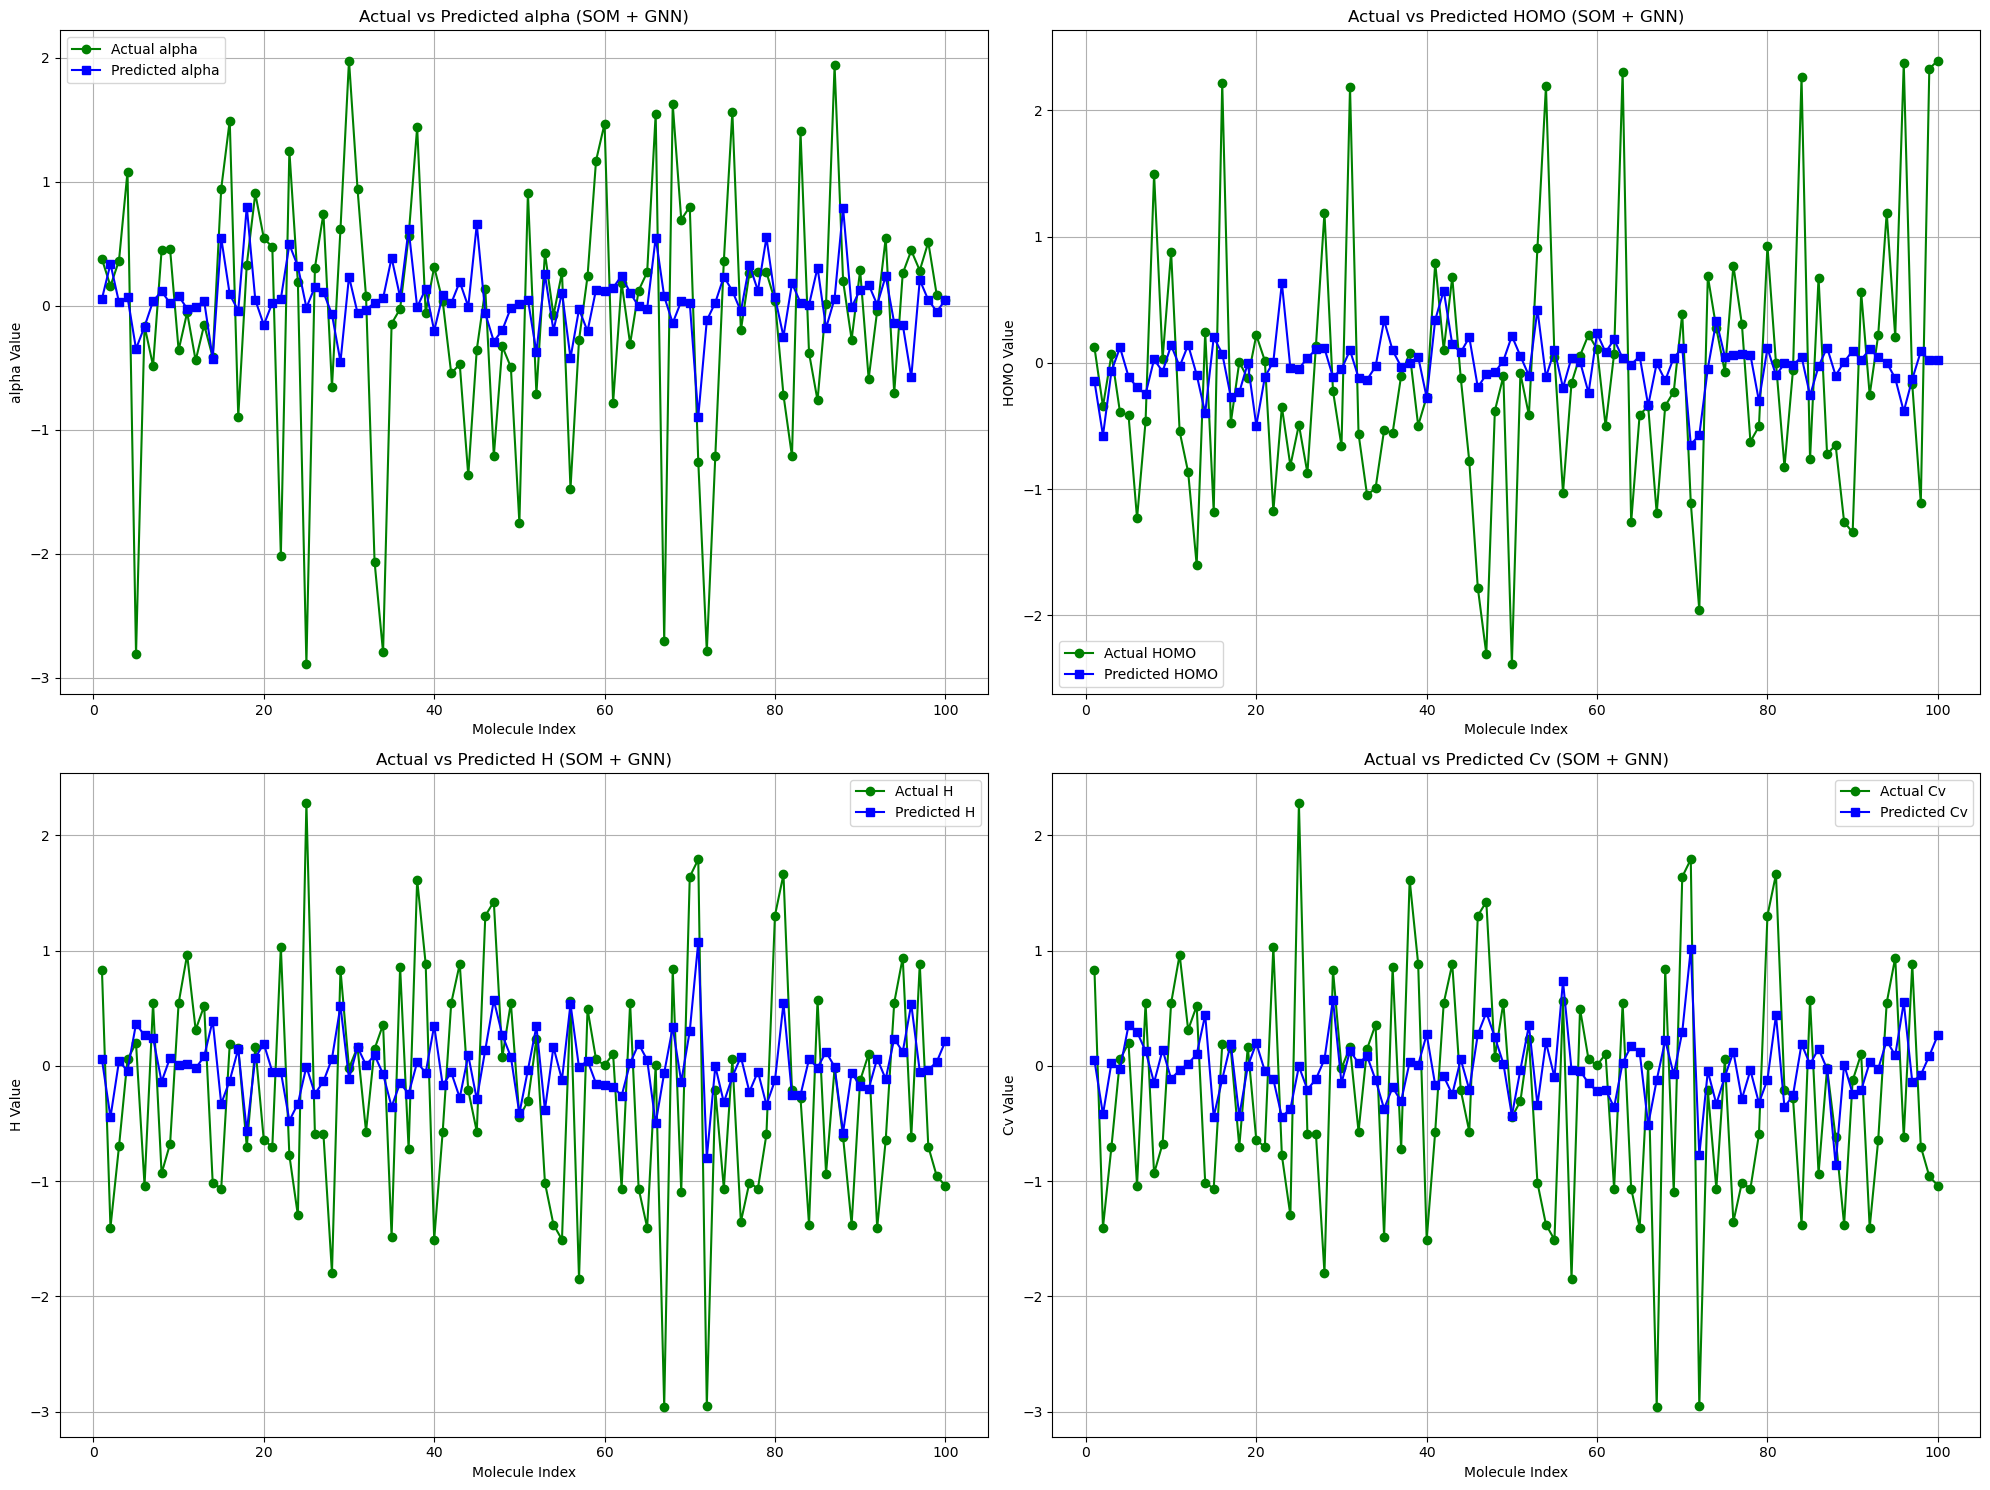

In [15]:
# 11. Plot results for each property
plt.figure(figsize=(20, 15))
for i, name in enumerate(property_names, 1):
    plt.subplot(2, 2, i)
    plt.plot(range(1, 101), actuals[name], label=f'Actual {name}', marker='o', color='green')
    plt.plot(range(1, 101), predictions[name], label=f'Predicted {name}', marker='s', color='blue')
    plt.xlabel("Molecule Index")
    plt.ylabel(f"{name} Value")
    plt.title(f"Actual vs Predicted {name} (SOM + GNN)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
import joblib
import os

# Create a directory to store saved files
os.makedirs("saved_model", exist_ok=True)

# Save model weights
torch.save(model.state_dict(), "saved_model/som_gnn_multitarget.pth")

# Save target scalers
for i, name in enumerate(property_names):
    joblib.dump(scalers[i], f"saved_model/scaler_{name}.pkl")

print(" Model and scalers saved!")


 Model and scalers saved!
